In [ ]:
!pip install d2l==0.14

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
%matplotlib inline

首先，我们像以前一样生成一些数据，生成公式如下：

(4.5.4)
y=0.05+∑i=1d 0.01xi+ϵ where ϵ∼N(0,0.012).
 
我们选择标签是关于输入的线性函数。标签同时被均值为0，标准差为0.01高斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到 d=200 ，并使用一个只包含20个样本的小训练集。

In [3]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化模型参数

In [4]:
def init_params():
  w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
  b=torch.zeros(1,requires_grad=True)
  return [w,b]

定义L2范数惩罚 L2正则的一部分

In [5]:
def l2_penalty(w):
  return torch.sum(w.pow(2))/2

定义训练代码实现

In [7]:
def train(lambd):
  w,b=init_params()
  net,loss=lambda X:d2l.linreg(X,w,b),d2l.squared_loss #匿名函数，冒号前表示参数，本身就有返回值
  num_epochs,lr=100,0.003
  animator=d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',xlim=[5, num_epochs], legend=['train', 'test'])
  for epoch in range(num_inputs):
    for X,y in train_iter:
      #with torch.enable_grad():
      l=loss(net(X),y)+lambd*l2_penalty(w) #计算损失
      l.sum().backward()#计算梯度
      d2l.sgd([w,b],lr,batch_size) #更新优化权重
    if(epoch+1)%5==0:
      animator.add(epoch+1,(d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))
  print('w的L2范数是：',torch.norm(w).item())

忽略正则化直接训练

w的L2范数是： 12.975935935974121


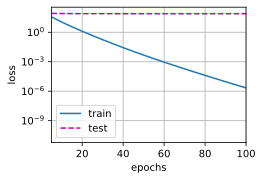

In [8]:
train(lambd=0)

使用权重衰减

w的L2范数是： 0.019215956330299377


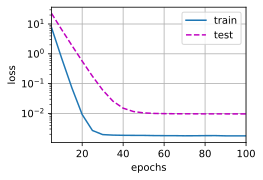

In [11]:
train(lambd=10)

简洁实现

In [12]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
      param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减。
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd}, { #既可以在最后目标函数中加lambd正则项，也可以在每次更新权重时乘一个小的值
            "params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #with torch.enable_grad():
          trainer.zero_grad()
          l = loss(net(X), y)
          l.backward()
          trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 0.10233315080404282


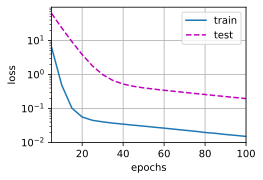

In [13]:
train_concise(8)